<a href="https://colab.research.google.com/github/namiyousef/hpc-utils/blob/main/experiments/colab/training_loop_debug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers
!pip install datasets
!pip install colab-dev-tools
!pip install pymannkendall

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.2 MB/s 
     |████████████████████████████████| 596 kB 68.8 MB/s 
     |████████████████████████████████| 6.6 MB 52.0 MB/s 
     |████████████████████████████████| 86 kB 6.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 362 kB 5.0 MB/s 
     |████████████████████████████████| 1.1 MB 61.4 MB/s 
     |████████████████████████████████| 212 kB 75.6 MB/s 
     |████████████████████████████████| 140 kB 74.4 MB/s 
     |████████████████████████████████| 127 kB 75.5 MB/s 
     |████████████████████████████████| 271 kB 72.5 MB/s 
     |████████████████████████████████| 94 kB 3.8 MB/s 
     |███████████████

In [2]:
import time
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_scheduler
from colabtools.utils import move_to_device, get_gpu_utilization
from colabtools.config import DEVICE
from datasets import load_dataset
import warnings
import logging
from torch.utils.data import Dataset, DataLoader
import torch
import gc
import pymannkendall as mk
import random
import numpy as np
import matplotlib.pyplot as plt


SEED = 0
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)

def update_confidence(confidence, epoch, inputs, outputs, targets):
  with torch.no_grad():
    outputs = torch.nn.functional.softmax(outputs, dim=1)
    instance_ids = inputs['instance_ids']
    # TODO double check this step

    # TODO try this, compare /w gather
    # outputs[torch.arange(outputs.size(0)), targets]

    confidence_ = torch.gather(outputs, 1, targets.reshape(-1,1)).flatten()
    confidence[instance_ids, epoch] = confidence_
  return confidence

class PawsXDataset(Dataset):

    def __init__(self, tokenizer, max_length, lang='en', split='train', data=None):
        super().__init__()

        self.tokenizer = tokenizer
        self.max_length = max_length

        if data is None:
            self.data = load_dataset('paws-x', lang, split=split)
            logging.info(f'Loaded paws-x dataset for lang={lang} and split={split}')
        else:
            self.data = data
            warnings.warn('Loading with custom data. User specified lang and split ignored.', UserWarning, stacklevel=2)

        self.length = len(self.data)


    def __len__(self):
        return self.length

    def __getitem__(self, index):
        item = self.data[index]
        sent1 = item['sentence1']
        sent2 = item['sentence2']
        label = item['label']

        inputs = self.tokenizer(
            sent1,
            sent2,
            max_length=self.max_length,
            truncation='only_first', # longest_first
            padding='max_length'
        )

        inputs['instance_ids'] = index

        inputs = {key: torch.tensor(item) for key, item in inputs.items()}
        outputs = torch.tensor(label)

        return (inputs, outputs)
def train(model, optimizer, train_loader, epochs, confidence, metrics=[], verbose=1, save_model_name='model'):
    scores = {}

    for epoch in range(epochs):
        model.train()
        start_epoch_message = f'EPOCH {epoch + 1} STARTED'
        print(start_epoch_message)
        print(f'{"-" * len(start_epoch_message)}')
        start_epoch = time.time()

        start_load = time.time()
        training_loss = 0
        # genuinely thinking should standardise this to just 'inputs_dict' and 'outputs_dict' from the model!
        for i, (inputs, targets) in enumerate(train_loader):
            start_train = time.time()
            inputs = move_to_device(inputs, DEVICE)
            targets = move_to_device(targets, DEVICE)

            optimizer.zero_grad()
            loss, outputs = model(
                labels=targets,
                input_ids=inputs['input_ids'],
                attention_mask=inputs['attention_mask'],
                return_dict=False
            )
            gpu_util = 'NO GPU' if DEVICE == 'cpu' else get_gpu_utilization()
            training_loss += loss.item()
            ALL_LOSSES.append(loss.item())


            loss.backward()
            optimizer.step()
            #lr_scheduler.step()

            # metrics
            for metric in metrics:
                score = metric(outputs, targets)
                scores['scores'][metric.__class__.__name__].append(score.item())

            # TODO need to upgrade learning scripts to allow for task specific confidence (e.g. if you want confidence for NER)
            confidence = update_confidence(confidence, epoch, inputs, outputs, targets)

            # TODO look into scheduler (initialise after optimizer, and also scheduler.step() after optimizer.step())
            # TODO see if deleting the loss deletes the comp. graph?
            # TODO look into huggingface text classification (for example) for PyTorch training, e.g. without trainer

            # TODO try w/o deleting/empty cache in general
            del targets, inputs, outputs
            gc.collect()
            torch.cuda.empty_cache()

            end_train = time.time()

            if verbose > 1:
                print(
                    f'Batch {i + 1} complete. '
                    f'Time taken: load({start_train - start_load:.3g}),'
                    f'train({end_train - start_train:.3g}),'
                    f'total({end_train - start_load:.3g}). '
                    f'GPU util. after train: {gpu_util}. '
                    f'Metrics: {" ".join([f"{metric_name}({score_list[-1]:.3g})" for metric_name, score_list in scores.get("scores", {}).items()])}'
                )
            start_load = time.time()

        for metric in metrics:
            score = scores['scores'][metric.__class__.__name__][:i + 1]
            avg_score = sum(score) / len(score)
            scores['epoch_scores'][metric.__class__.__name__].append(avg_score)
            scores['epoch_batch_ids'][metric.__class__.__name__].append(i)

        print_message = f'Epoch {epoch + 1}/{epochs} complete. ' \
                        f'Time taken: {start_load - start_epoch:.3g}. ' \
                        f'Loss: {training_loss / (i + 1): .3g}. ' \
                        f'Metrics: {" ".join([f"{metric_name}({score_list[-1]:.3g})" for metric_name, score_list in scores.get("epoch_scores", {}).items()])}'

        if verbose:
            print(f'{"-" * len(print_message)}')
            print(print_message)
            print(f'{"-" * len(print_message)}')

    #encoded_model_name = encode_model_name(save_model_name, epoch+1)
    #save_path = f'models/{encoded_model_name}'
    #model.save_pretrained(save_path)
    #print(f'Model saved at epoch {epoch+1} at: {save_path}')

    return confidence

Google Drive import successful.
CUDA device detected. Using GPU...


In [3]:
model_name = 'xlm-roberta-base'
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2).to(DEVICE)
tokenizer = AutoTokenizer.from_pretrained(model_name)
#optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
optimizer = AdamW(model.parameters(), lr=3e-5)

Downloading:   0%|          | 0.00/615 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.04G [00:00<?, ?B/s]

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

Downloading:   0%|          | 0.00/4.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/8.68M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [4]:
max_length = 128
epochs = 10

dataset = PawsXDataset(tokenizer, max_length, split='validation')
dataloader = DataLoader(dataset, batch_size=16)
num_training_steps = epochs * len(dataloader)
#lr_scheduler = get_scheduler(
#    "linear",
#    optimizer=optimizer,
#    num_warmup_steps=0,
#    num_training_steps=num_training_steps,
#)

Generating train split:   0%|          | 0/49401 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset paws-x downloaded and prepared to /root/.cache/huggingface/datasets/paws-x/en/1.1.0/37673404a6de6d0fa2574661e77940d10d3be3bf51bb4f08c8fa079fd56b9755. Subsequent calls will reuse this data.


In [5]:
ALL_LOSSES = []

confidence = torch.zeros((len(dataset), epochs), dtype=torch.float32).to(DEVICE)

confidence = train(model, optimizer, dataloader, epochs, confidence, verbose=2)

EPOCH 1 STARTED
---------------
Batch 1 complete. Time taken: load(0.0198),train(0.747),total(0.767). GPU util. after train: 4080. Metrics: 
Batch 2 complete. Time taken: load(0.00903),train(0.507),total(0.516). GPU util. after train: 7338. Metrics: 
Batch 3 complete. Time taken: load(0.00924),train(0.509),total(0.518). GPU util. after train: 7338. Metrics: 
Batch 4 complete. Time taken: load(0.0122),train(0.507),total(0.519). GPU util. after train: 7338. Metrics: 
Batch 5 complete. Time taken: load(0.00884),train(0.509),total(0.518). GPU util. after train: 7338. Metrics: 
Batch 6 complete. Time taken: load(0.00925),train(0.511),total(0.52). GPU util. after train: 7338. Metrics: 
Batch 7 complete. Time taken: load(0.00935),train(0.509),total(0.518). GPU util. after train: 7338. Metrics: 
Batch 8 complete. Time taken: load(0.0123),train(0.505),total(0.518). GPU util. after train: 7338. Metrics: 
Batch 9 complete. Time taken: load(0.00891),train(0.508),total(0.517). GPU util. after train

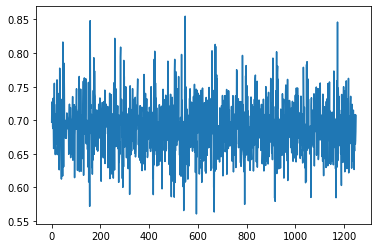

In [6]:
import matplotlib.pyplot as plt
plt.plot(ALL_LOSSES)

In [7]:
result = mk.original_test(ALL_LOSSES)
result




Mann_Kendall_Test(trend='no trend', h=False, p=0.17613175521843827, z=-1.3527617526791482, Tau=-0.025544915932746198, s=-19941.0, var_s=217273958.33333334, slope=-4.348957201407078e-06, intercept=0.6908442163328561)

In [8]:

def plot_nn_metric(metric_data, batch_size=None, epoch=None, label=None):
  steps = range(len(metric_data))

  plt.plot(steps, metric_data)